In [7]:
"""Accounting methods

Generating P&L with different accounting methods (FIFO and LIFO)

Attributes
----------
cocoon
transaction configuration
derived portfolios
accounting methods
"""
## Import Libraries & Connect to LUSID

'Accounting methods\n\nGenerating P&L with different accounting methods (FIFO and LIFO)\n\nAttributes\n----------\ncocoon\ntransaction configuration\nderived portfolios\naccounting methods\n'

In [8]:
# Import LUSID
import lusid
import lusidtools.cocoon.cocoon as cocoon_tools
import lusid_sample_data as sd
from lusidjam import RefreshingToken
import pandas as pd
import numpy as np
import os
import pytz
import printer as prettyprint
from datetime import datetime
import pylab
import matplotlib.pyplot as plt

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

In [9]:
%matplotlib inline
%pylab inline

# Set style to fivethirtyeight to create clean and clear looking graphs
plt.style.use('fivethirtyeight')

# Define a dictionary containing default plotting configurations
params = {
    'legend.fontsize': 'small',
    'figure.figsize': (15, 10),
    'axes.labelsize': 'small',
    'axes.titlesize':'medium',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small'
}

pylab.rcParams.update(params)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/adammassoud/work/code/repos/sample-notebooks-1/.venv/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['pylab', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Import and Create Instruments

In [10]:
uk_instrument_master = pd.read_csv("data/global-fund-UK-instrument-master.csv")
uk_instrument_master.head(n=20)

,instrument_name,client_internal,currency,isin,figi,exchange_code,country_issue,ticker,market_sector,security_type,coupon,s&p rating
0,BP_LondonStockEx_BP,imd_43535553,GBP,GB0007980591,BBG000C05BD1,LN,united_kingdom,BP/,equity,common_stock,NaN,NaN
1,BurfordCapital_LondonStockEx_BUR,imd_43534356,GBP,GG00B4L84979,BBG000PN88Q7,LN,united_kingdom,BUR,equity,common_stock,NaN,NaN
2,EKFDiagnostics_LondonStockEx_EKF,imd_34535355,GBP,GB0031509804,BBG000BVNBN3,LN,united_kingdom,EKF,equity,common_stock,NaN,NaN
3,Glencore_LondonStockEx_GLEN,imd_34534555,GBP,JE00B4T3BW64,BBG001MM1KV4,LN,united_kingdom,GLEN,equity,common_stock,NaN,NaN
4,JustEat_LondonStockEx_JE,imd_35436366,GBP,GB00BKX5CN86,BBG0065YWM39,LN,united_kingdom,JE/,equity,common_stock,NaN,NaN
5,Kingfisher_LondonStockEx_KGF,imd_34535552,GBP,GB0033195214,BBG000BKH1W6,LN,united_kingdom,KGF,equity,common_stock,NaN,NaN
6,MicroFocus_LondonStockEx_MCRO,imd_34567338,GBP,GB00BD8YWM01,BBG000G4KKD2,LN,united_kingdom,MCRO,equity,common_stock,NaN,NaN
7,RELXGroup_LondonStockEx_REL,imd_43532542,GBP,GB00B2B0DG97,BBG000D03XD4,LN,united_kingdom,REL,equity,common_stock,NaN,NaN
8,Sage_LondonStockEx_SGE,imd_23536673,GBP,GB00B8C3BL03,BBG000BN0PP3,LN,united_kingdom,SGE,equity,common_stock,NaN,NaN
9,TESCO_LondonStockEx_TSCO,imd_34634673,GBP,GB0008847096,BBG000BF46Y8,LN,united_kingdom,TSCO,equity,common_stock,NaN,NaN


In [11]:
instrument_properties_scope = 'InstrumentProperties005'

instrument_identifier_mapping = {
    "Figi": "figi",
    "Isin": "isin",
    "ClientInternal": "client_internal",
    "Ticker": "ticker"
}

instrument_mapping_required = {
    "name": "instrument_name"
}

instrument_mapping_optional = {}

responses = cocoon_tools.load_from_data_frame(
    api_factory=api_factory, 
    scope=instrument_properties_scope, 
    data_frame=uk_instrument_master, 
    mapping_required=instrument_mapping_required, 
    mapping_optional=instrument_mapping_optional, 
    file_type="instrument", 
    identifier_mapping=instrument_identifier_mapping, 
    property_columns=[
        "exchange_code", 
        "country_issue", 
        "market_sector",
        "security_type",
        "coupon",
        "s&p rating",
        "currency"])

prettyprint.instrument_response(responses["instruments"]["success"][0])

/Users/adammassoud/work/code/repos/sample-notebooks-1/.venv/lib/python3.11/site-packages/lusidtools/cocoon/cocoon.py:1720: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_frame = data_frame.applymap(cocoon.utilities.convert_cell_value_to_string)


Instruments Successfully Upserted: 


,Instrument,ClientInternal ID,LUSID Instrument ID
0,ClientInternal: imd_43534356,imd_43534356,LUID_0000MIOY
1,ClientInternal: imd_34534536,imd_34534536,LUID_0000MIP3
2,ClientInternal: imd_35436366,imd_35436366,LUID_0000MIP4
3,ClientInternal: imd_34534555,imd_34534555,LUID_0000MIPD
4,ClientInternal: imd_34567338,imd_34567338,LUID_0000MIP9
5,ClientInternal: imd_43532542,imd_43532542,LUID_0000MIOW
6,ClientInternal: imd_34534534,imd_34534534,LUID_0000MIPA
7,ClientInternal: imd_43535553,imd_43535553,LUID_00044OXX
8,ClientInternal: imd_54234532,imd_54234532,LUID_0000MIPC
9,ClientInternal: imd_34536734,imd_34536734,LUID_0000MIPF


## Create a Portfolio with "FirstInFirstOut" (FIFO) Accounting Method

In [12]:
portfolio_code = "UK12XC2"

portfolio = pd.DataFrame([
    {
        "code": portfolio_code,
        "display_name": "UK Equity Fund",
        "description": "UK Growth Fund Trading in UK Tradeable Equities",
        "base_currency": "GBP",
        "accounting_method": "FirstInFirstOut",
        "created": datetime.datetime(year=2010, day=1, month=1, tzinfo=pytz.UTC)
    }
])

portfolio.head()

,code,display_name,description,base_currency,accounting_method,created
0,UK12XC2,UK Equity Fund,UK Growth Fund Trading in UK Tradeable Equities,GBP,FirstInFirstOut,2010-01-01 00:00:00+00:00


In [13]:
trading_scope = "AccountingDemoScope"

portfolio_mapping_required = {
    "code": "code",
    "display_name": "display_name",
    "base_currency": "base_currency",
    "accounting_method": "accounting_method"
}

portfolio_mapping_optional = {
    "description": "description",
    "created": "created"
}

responses = cocoon_tools.load_from_data_frame(
    api_factory=api_factory, 
    scope=trading_scope, 
    data_frame=portfolio, 
    mapping_required=portfolio_mapping_required, 
    mapping_optional=portfolio_mapping_optional, 
    file_type="portfolio")

prettyprint.portfolio_response(responses["portfolios"]["success"][0])

/Users/adammassoud/work/code/repos/sample-notebooks-1/.venv/lib/python3.11/site-packages/lusidtools/cocoon/cocoon.py:1720: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_frame = data_frame.applymap(cocoon.utilities.convert_cell_value_to_string)


Portfolio Created
Scope: AccountingDemoScope
Code: UK12XC2
Portfolio Effective From: 2010-01-01 00:00:00+00:00
Portfolio Created On: 2023-12-27 16:16:15.201798+00:00



## Import and Create Transactions for September 2019

In [14]:
transactions = pd.read_csv("data/accounting-demo-sample-transactions.csv")
transactions["cash_transactions"] = np.where(transactions["desc"] == "FundsIn", transactions["trade_currency"], np.NaN) 
transactions.head(n=20)

,desc,qty,unit_price,trade_currency,exposure,total_trade_amount,figi_identifier,trade_datetime,settlement_datetime,isin_identifier,executor,asset_name,fund_code,t_id,internal_identifier,cash_transactions
0,FundsIn,900000000,1.00,GBP,NaN,95000000.00,NaN,2019-09-01T09:31:22.664000+00:00,2019-09-01T09:31:22.664000+00:00,NaN,jx112421,GBP,UK12XC2,kjk99898990z88908,NaN,GBP
1,Buy,729176,5.92,GBP,BP,3996759.49,BBG000C05BD1,2019-09-03T14:42:12.435000+00:00,2019-09-05T14:42:12.435000+00:00,GB0007980591,jx112421,BP_LondonStockEx_BP,UK12XC2,435opkplk03sfsf33,imd_43535553,NaN
2,Buy,1762711,8.85,GBP,BurfordCapital,15599992.35,BBG000PN88Q7,2019-09-05T15:12:44.090000+00:00,2019-09-07T15:12:44.090000+00:00,GG00B4L84979,jx112421,BurfordCapital_LondonStockEx_BUR,UK12XC2,dsfsdlkjs933234211,imd_43534356,NaN
3,Buy,14087318,2.40,GBP,Glencore,33879999.79,BBG001MM1KV4,2019-09-10T09:58:43.112000+00:00,2019-09-11T09:58:43.112000+00:00,JE00B4T3BW64,jx112421,Glencore_LondonStockEx_GLEN,UK12XC2,dfklsjd90232350239,imd_34534555,NaN
4,Buy,276624,7.42,GBP,JustEat,2051996.83,BBG0065YWM39,2019-09-10T13:58:57.113000+00:00,2019-09-11T13:58:57.113000+00:00,GB00BKX5CN86,jp392431,JustEat_LondonStockEx_J,UK12XC2,kj0llk90f0909201141,imd_35436366,NaN
5,Buy,500000,10.50,GBP,MicroFocus,5249000.00,BBG000G4KKD2,2019-09-12T15:32:57.113000+00:00,2019-09-14T15:32:57.113000+00:00,GB00BD8YWM01,jx112421,MicroFocus_LondonStockEx_MCRO,UK12XC2,sadjkas934234sadfs,imd_34567338,NaN
6,Buy,543176,5.10,GBP,BP,2829240.83,BBG000C05BD1,2019-09-13T16:29:18.123000+00:00,2019-09-15T16:29:18.123000+00:00,GB0007980591,jp392431,BP_LondonStockEx_BP,UK12XC2,fas2340090sd9f0s23,imd_43535553,NaN
7,Buy,853000,8.83,GBP,BurfordCapital,7531990.00,BBG000PN88Q7,2019-09-15T10:58:57.113000+00:00,2019-09-17T10:58:57.113000+00:00,GG00B4L84979,jx112421,BurfordCapital_LondonStockEx_BUR,UK12XC2,dflkjsdflk932432rsd,imd_43534356,NaN
8,Buy,9349219,2.41,GBP,Glencore,22503570.13,BBG001MM1KV4,2019-09-16T09:32:38.113000+00:00,2019-09-18T09:32:38.113000+00:00,JE00B4T3BW64,jp392431,Glencore_LondonStockEx_GLEN,UK12XC2,sdfdslkf234092304s,imd_34534555,NaN
9,Sell,854176,5.32,GBP,BP,4548060.11,BBG000C05BD1,2019-09-19T09:32:38.113000+00:00,2019-09-21T09:32:38.113000+00:00,GB0007980591,jp392431,BP_LondonStockEx_BP,UK12XC2,2354lafjaso3432502,imd_43535553,NaN


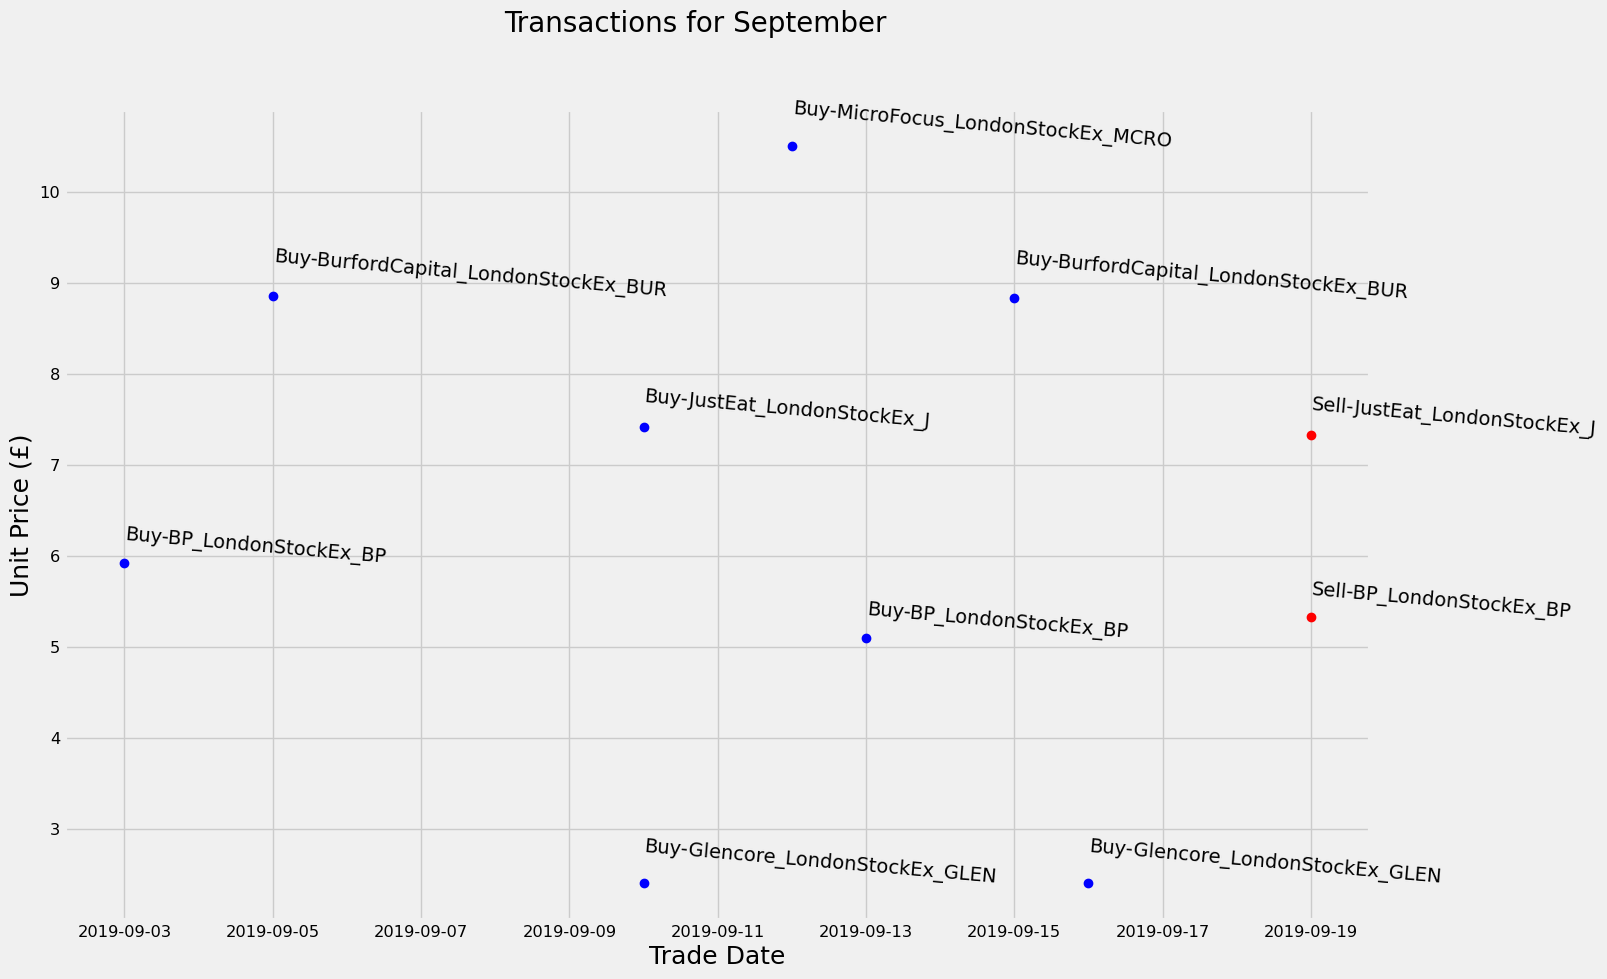

In [15]:
x = [datetime.date.fromisoformat(date.split("T")[0]) for date in transactions["trade_datetime"].values[1:]]
y = transactions["unit_price"].values[1:]
labels = [
    "-".join([
        transactions["desc"].values[i], 
        transactions["asset_name"].values[i]
    ]) for i in range(1, len(transactions["desc"].values))]

fig, ax = plt.subplots()
for x, y, label in zip(x,y,labels):
    if "Buy" in label:
        colour = "blue"
    else:
        colour = "red"

    ax.plot_date(x=x, y=y, c=colour)
    ax.annotate(label, (x, y), rotation=-5)

plt.xlabel('Trade Date', fontsize=18)
plt.ylabel('Unit Price (£)', fontsize=18)
fig.suptitle('Transactions for September', fontsize=20)
plt.show()

In [16]:
transaction_identifier_mapping = {
    "Figi": "figi_identifier",
    "Isin": "isin_identifier",
    "ClientInternal": "internal_identifier",
    "Currency": "cash_transactions"
}

transaction_mapping_required = {
    "code": "fund_code",
    "transaction_id": "t_id",
    "type": "desc",
    "transaction_date": "trade_datetime",
    "settlement_date": "settlement_datetime",
    "units": "qty",
    "transaction_price.price": "unit_price",
    "transaction_price.type": "$Price",
    "total_consideration.amount": "total_trade_amount",
    "total_consideration.currency": "trade_currency"
}

transaction_mapping_optional = {
    "exchange_rate": "$1",
    "transaction_currency": "trade_currency"
}

responses = cocoon_tools.load_from_data_frame(
    api_factory=api_factory, 
    scope=trading_scope, 
    data_frame=transactions, 
    mapping_required=transaction_mapping_required, 
    mapping_optional=transaction_mapping_optional, 
    file_type="transactions", 
    identifier_mapping=transaction_identifier_mapping, 
    property_columns=[
        "exposure",
        "executor",
        "asset_name"
    ])

prettyprint.transactions_response(
    responses["transactions"]["success"][0], 
    trading_scope, 
    responses["transactions"]["success"][0].href.split("/")[7])

/Users/adammassoud/work/code/repos/sample-notebooks-1/.venv/lib/python3.11/site-packages/lusidtools/cocoon/cocoon.py:1720: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_frame = data_frame.applymap(cocoon.utilities.convert_cell_value_to_string)


Transactions Successfully Upserted into Portfolio
Scope: AccountingDemoScope
Code: UK12XC2
Transactions Effective From: 2010-01-01 00:00:00+00:00
Transactions Created On: 2019-11-18 11:46:36.561221+00:00



## Generate Holdings by Tax Lot At 30th September 2019

In [17]:
response = api_factory.build(lusid.api.TransactionPortfoliosApi).get_holdings(
    scope=trading_scope,
    code=portfolio_code,
    property_keys=[
        "Instrument/default/Name",
        "Instrument/default/Figi",
        f"Instrument/{instrument_properties_scope}/security_type"
    ],
    by_taxlots=True,
    effective_at=datetime.datetime(year=2019, month=9, day=30, hour=12, tzinfo=pytz.UTC))

prettyprint.get_holdings_df(response)

,local_vars_configuration,_instrument_scope,_instrument_uid,_holding_type,_units,_settled_units,_transaction,_currency,_holding_type_name,_holding_id,...,cost.currency,cost_portfolio_ccy.amount,Instrument/default/Figi,Instrument/default/Name,Holding/default/SourcePortfolioId,Holding/default/SourcePortfolioScope,Holding/default/TaxlotPurchaseDate,Holding/default/TaxlotPurchasePrice,Holding/default/TaxlotId,Instrument/InstrumentProperties005/security_type
0,<lusid.configuration.Configuration object at 0...,default,CCY_GBP,B,812026970.09,812026970.09,None,GBP,Balance,7590391,...,GBP,812026970.09,some-figi-code12312,GBP,UK12XC2,AccountingDemoScope,NaN,NaN,NaN,NaN
1,<lusid.configuration.Configuration object at 0...,default,LUID_00044OXX,P,418176.00,418176.00,None,GBP,Position,7590396,...,GBP,2178153.33,BBG000C05BD1,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,2019-09-13T16:29:18.1230000+00:00,5.10,fas2340090sd9f0s23,common_stock
2,<lusid.configuration.Configuration object at 0...,default,LUID_0000MIOY,P,1762711.00,1762711.00,None,GBP,Position,7590392,...,GBP,15599992.35,BBG000PN88Q7,BurfordCapital_LondonStockEx_BUR,UK12XC2,AccountingDemoScope,2019-09-05T15:12:44.0900000+00:00,8.85,dsfsdlkjs933234211,common_stock
3,<lusid.configuration.Configuration object at 0...,default,LUID_0000MIOY,P,853000.00,853000.00,None,GBP,Position,7590392,...,GBP,7531990.00,BBG000PN88Q7,BurfordCapital_LondonStockEx_BUR,UK12XC2,AccountingDemoScope,2019-09-15T10:58:57.1130000+00:00,8.83,dflkjsdflk932432rsd,common_stock
4,<lusid.configuration.Configuration object at 0...,default,LUID_0000MIPD,P,14087318.00,14087318.00,None,GBP,Position,7590395,...,GBP,33879999.79,BBG001MM1KV4,Glencore_LondonStockEx_GLEN,UK12XC2,AccountingDemoScope,2019-09-10T09:58:43.1120000+00:00,2.40,dfklsjd90232350239,common_stock
5,<lusid.configuration.Configuration object at 0...,default,LUID_0000MIPD,P,9349219.00,9349219.00,None,GBP,Position,7590395,...,GBP,22503570.13,BBG001MM1KV4,Glencore_LondonStockEx_GLEN,UK12XC2,AccountingDemoScope,2019-09-16T09:32:38.1130000+00:00,2.41,sdfdslkf234092304s,common_stock
6,<lusid.configuration.Configuration object at 0...,default,LUID_0000MIP4,P,123624.00,123624.00,None,GBP,Position,7590393,...,GBP,917042.83,BBG0065YWM39,JustEat_LondonStockEx_JE,UK12XC2,AccountingDemoScope,2019-09-10T13:58:57.1130000+00:00,7.42,kj0llk90f0909201141,common_stock
7,<lusid.configuration.Configuration object at 0...,default,LUID_0000MIP9,P,500000.00,500000.00,None,GBP,Position,7590394,...,GBP,5249000.00,BBG000G4KKD2,MicroFocus_LondonStockEx_MCRO,UK12XC2,AccountingDemoScope,2019-09-12T15:32:57.1130000+00:00,10.50,sadjkas934234sadfs,common_stock


## Generate P/L for September 2019

In [18]:
response = api_factory.build(lusid.api.TransactionPortfoliosApi).build_transactions(
    scope=trading_scope,
    code=portfolio_code,
    transaction_query_parameters=lusid.models.TransactionQueryParameters(
        start_date=datetime.datetime(year=2019, month=9, day=1, hour=0, tzinfo=pytz.UTC).isoformat(),
        end_date=datetime.datetime(year=2019, month=9, day=30, hour=0, tzinfo=pytz.UTC).isoformat(),
        query_mode="TradeDate"
        )
    )

profit_loss_fifo = prettyprint.output_transactions(response, trading_scope, portfolio_code)
profit_loss_fifo["accounting_method"] = "FIFO"
profit_loss_fifo

Output Transactions for Portfolio
Scope: AccountingDemoScope
Code: UK12XC2



,Transaction ID,Transaction Type,Transaction/AccountingDemoScope/executor,Transaction/AccountingDemoScope/asset_name,Transaction/default/SourcePortfolioId,Transaction/default/SourcePortfolioScope,Transaction/AccountingDemoScope/exposure,Transaction/default/ResultantHolding,Units,Price,Currency,Transaction Date,Settlement Date,Realised Gain Loss,0,accounting_method
0,2354lafjaso3432502,Sell,jp392431,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,BP,NaN,854176.00,5.32,GBP,2019-09-19 09:32:38.113000+00:00,2019-09-21 09:32:38.113000+00:00,-99786.88,NaN,FIFO
1,sdlfksdlfk23409235,Sell,jp392431,JustEat_LondonStockEx_J,UK12XC2,AccountingDemoScope,JustEat,NaN,153000.00,7.33,GBP,2019-09-19 09:32:38.113000+00:00,2019-09-21 09:32:38.113000+00:00,-13494.60,NaN,FIFO
2,kjk99898990z88908,FundsIn,jx112421,GBP,UK12XC2,AccountingDemoScope,900000000.00,1.00,GBP,2019-09-01 09:31:22.664000+00:00,2019-09-01 09:31:22.664000+00:00,NaT,NaT,NaN,NaN,FIFO
3,435opkplk03sfsf33,Buy,jx112421,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,BP,NaN,729176.00,5.92,GBP,2019-09-03 14:42:12.435000+00:00,2019-09-05 14:42:12.435000+00:00,NaN,NaN,FIFO
4,dsfsdlkjs933234211,Buy,jx112421,BurfordCapital_LondonStockEx_BUR,UK12XC2,AccountingDemoScope,BurfordCapital,NaN,1762711.00,8.85,GBP,2019-09-05 15:12:44.090000+00:00,2019-09-07 15:12:44.090000+00:00,NaN,NaN,FIFO
5,dfklsjd90232350239,Buy,jx112421,Glencore_LondonStockEx_GLEN,UK12XC2,AccountingDemoScope,Glencore,NaN,14087318.00,2.40,GBP,2019-09-10 09:58:43.112000+00:00,2019-09-11 09:58:43.112000+00:00,NaN,NaN,FIFO
6,kj0llk90f0909201141,Buy,jp392431,JustEat_LondonStockEx_J,UK12XC2,AccountingDemoScope,JustEat,NaN,276624.00,7.42,GBP,2019-09-10 13:58:57.113000+00:00,2019-09-11 13:58:57.113000+00:00,NaN,NaN,FIFO
7,sadjkas934234sadfs,Buy,jx112421,MicroFocus_LondonStockEx_MCRO,UK12XC2,AccountingDemoScope,MicroFocus,NaN,500000.00,10.50,GBP,2019-09-12 15:32:57.113000+00:00,2019-09-14 15:32:57.113000+00:00,NaN,NaN,FIFO
8,fas2340090sd9f0s23,Buy,jp392431,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,BP,NaN,543176.00,5.10,GBP,2019-09-13 16:29:18.123000+00:00,2019-09-15 16:29:18.123000+00:00,NaN,NaN,FIFO
9,dflkjsdflk932432rsd,Buy,jx112421,BurfordCapital_LondonStockEx_BUR,UK12XC2,AccountingDemoScope,BurfordCapital,NaN,853000.00,8.83,GBP,2019-09-15 10:58:57.113000+00:00,2019-09-17 10:58:57.113000+00:00,NaN,NaN,FIFO


## Create Derived Portfolio with "LastInFirstOut" accounting method and Generate P/L

In [19]:
try:
    response = api_factory.build(lusid.api.PortfoliosApi).get_portfolio(
        scope=trading_scope,
        code=portfolio_code+"LIFO")
    
except lusid.exceptions.ApiException as e:
    if e.status == 404:
        response = api_factory.build(lusid.api.DerivedTransactionPortfoliosApi).create_derived_portfolio(
            scope=trading_scope,
            create_derived_transaction_portfolio_request=lusid.models.CreateDerivedTransactionPortfolioRequest(
                code=portfolio_code+"LIFO",
                display_name="LIFO Accounting treatment for the fund",
                parent_portfolio_id=lusid.models.ResourceId(
                    scope=trading_scope,
                    code=portfolio_code),
                accounting_method="LastInFirstOut",
                created=datetime.datetime(year=2010, month=1, day=1, tzinfo=pytz.UTC).isoformat()
            )
        )

prettyprint.portfolio_response(response)

Derived Portfolio Created
Scope: AccountingDemoScope
Code: UK12XC2LIFO
Portfolio Effective From: 2010-01-01 00:00:00+00:00
Portfolio Created On: 2023-12-27 16:16:34.916326+00:00

   Parent Portfolio Details
   Scope: AccountingDemoScope
   Code: UK12XC2



In [20]:
response = api_factory.build(lusid.api.TransactionPortfoliosApi).build_transactions(
    scope=trading_scope,
    code=portfolio_code+"LIFO",
    transaction_query_parameters=lusid.models.TransactionQueryParameters(
        start_date=datetime.datetime(year=2019, month=9, day=1, hour=0, tzinfo=pytz.UTC).isoformat(),
        end_date=datetime.datetime(year=2019, month=9, day=30, hour=0, tzinfo=pytz.UTC).isoformat(),
        query_mode="TradeDate"
        )
    )

profit_loss_lifo = prettyprint.output_transactions(response, trading_scope, portfolio_code+"LIFO")
profit_loss_lifo["accounting_method"] = "LIFO"
profit_loss_lifo

Output Transactions for Portfolio
Scope: AccountingDemoScope
Code: UK12XC2LIFO



,Transaction ID,Transaction Type,Transaction/AccountingDemoScope/executor,Transaction/AccountingDemoScope/asset_name,Transaction/default/SourcePortfolioId,Transaction/default/SourcePortfolioScope,Transaction/AccountingDemoScope/exposure,Transaction/default/ResultantHolding,Units,Price,Currency,Transaction Date,Settlement Date,Realised Gain Loss,0,accounting_method
0,sdlfksdlfk23409235,Sell,jp392431,JustEat_LondonStockEx_J,UK12XC2,AccountingDemoScope,JustEat,NaN,153000.00,7.33,GBP,2019-09-19 09:32:38.113000+00:00,2019-09-21 09:32:38.113000+00:00,-13494.60,NaN,LIFO
1,2354lafjaso3432502,Sell,jp392431,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,BP,NaN,854176.00,5.32,GBP,2019-09-19 09:32:38.113000+00:00,2019-09-21 09:32:38.113000+00:00,14166.08,NaN,LIFO
2,kjk99898990z88908,FundsIn,jx112421,GBP,UK12XC2,AccountingDemoScope,900000000.00,1.00,GBP,2019-09-01 09:31:22.664000+00:00,2019-09-01 09:31:22.664000+00:00,NaT,NaT,NaN,NaN,LIFO
3,435opkplk03sfsf33,Buy,jx112421,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,BP,NaN,729176.00,5.92,GBP,2019-09-03 14:42:12.435000+00:00,2019-09-05 14:42:12.435000+00:00,NaN,NaN,LIFO
4,dsfsdlkjs933234211,Buy,jx112421,BurfordCapital_LondonStockEx_BUR,UK12XC2,AccountingDemoScope,BurfordCapital,NaN,1762711.00,8.85,GBP,2019-09-05 15:12:44.090000+00:00,2019-09-07 15:12:44.090000+00:00,NaN,NaN,LIFO
5,dfklsjd90232350239,Buy,jx112421,Glencore_LondonStockEx_GLEN,UK12XC2,AccountingDemoScope,Glencore,NaN,14087318.00,2.40,GBP,2019-09-10 09:58:43.112000+00:00,2019-09-11 09:58:43.112000+00:00,NaN,NaN,LIFO
6,kj0llk90f0909201141,Buy,jp392431,JustEat_LondonStockEx_J,UK12XC2,AccountingDemoScope,JustEat,NaN,276624.00,7.42,GBP,2019-09-10 13:58:57.113000+00:00,2019-09-11 13:58:57.113000+00:00,NaN,NaN,LIFO
7,sadjkas934234sadfs,Buy,jx112421,MicroFocus_LondonStockEx_MCRO,UK12XC2,AccountingDemoScope,MicroFocus,NaN,500000.00,10.50,GBP,2019-09-12 15:32:57.113000+00:00,2019-09-14 15:32:57.113000+00:00,NaN,NaN,LIFO
8,fas2340090sd9f0s23,Buy,jp392431,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,BP,NaN,543176.00,5.10,GBP,2019-09-13 16:29:18.123000+00:00,2019-09-15 16:29:18.123000+00:00,NaN,NaN,LIFO
9,dflkjsdflk932432rsd,Buy,jx112421,BurfordCapital_LondonStockEx_BUR,UK12XC2,AccountingDemoScope,BurfordCapital,NaN,853000.00,8.83,GBP,2019-09-15 10:58:57.113000+00:00,2019-09-17 10:58:57.113000+00:00,NaN,NaN,LIFO


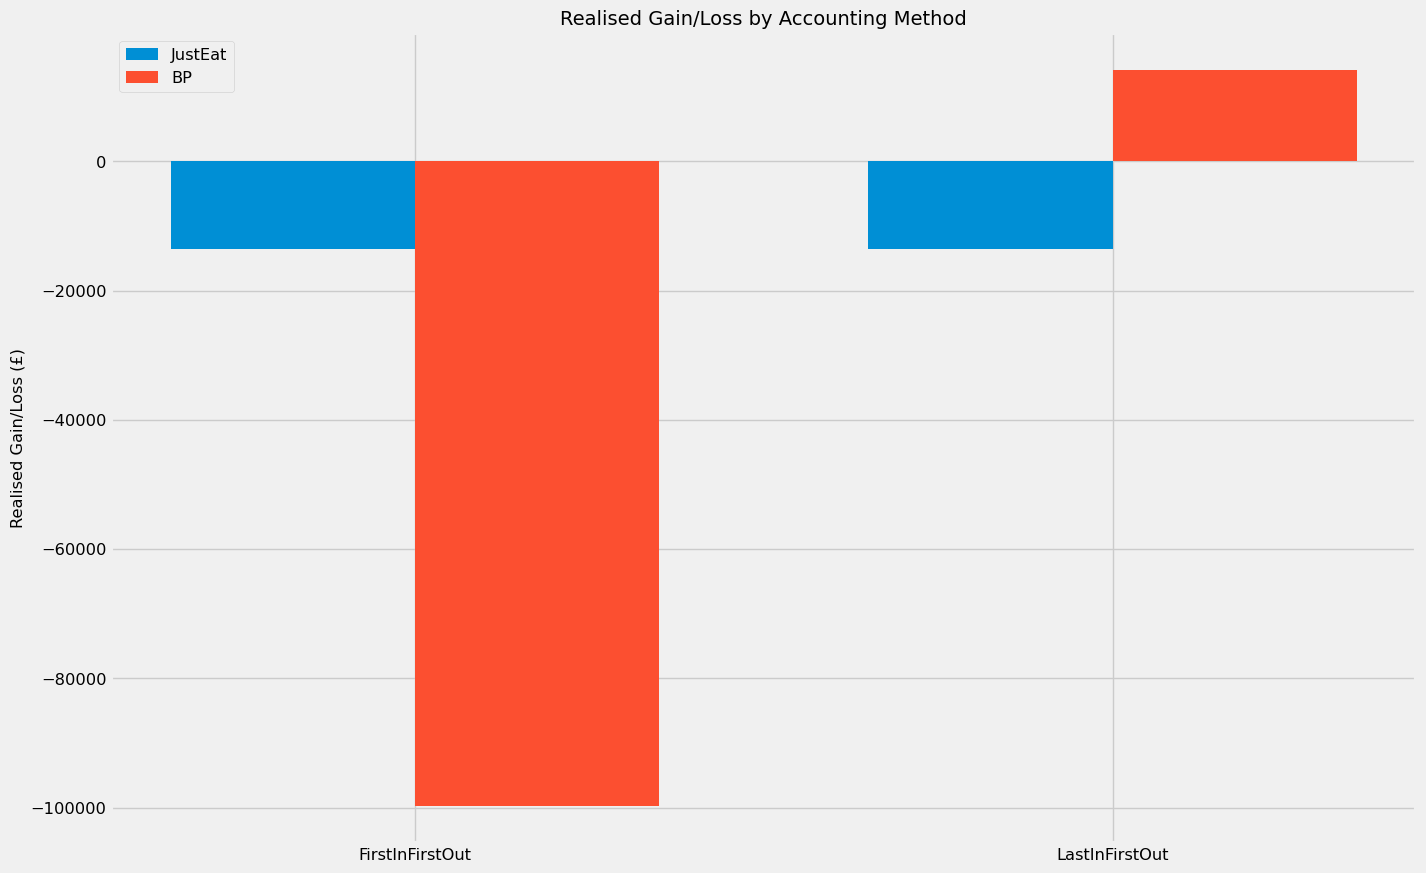

,Transaction ID,Transaction Type,Transaction/AccountingDemoScope/executor,Transaction/AccountingDemoScope/asset_name,Transaction/default/SourcePortfolioId,Transaction/default/SourcePortfolioScope,Transaction/AccountingDemoScope/exposure,Transaction/default/ResultantHolding,Units,Price,Currency,Transaction Date,Settlement Date,Realised Gain Loss,0,accounting_method
0,2354lafjaso3432502,Sell,jp392431,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,BP,NaN,854176.00,5.32,GBP,2019-09-19 09:32:38.113000+00:00,2019-09-21 09:32:38.113000+00:00,-99786.88,NaN,FIFO
1,sdlfksdlfk23409235,Sell,jp392431,JustEat_LondonStockEx_J,UK12XC2,AccountingDemoScope,JustEat,NaN,153000.00,7.33,GBP,2019-09-19 09:32:38.113000+00:00,2019-09-21 09:32:38.113000+00:00,-13494.60,NaN,FIFO
0,sdlfksdlfk23409235,Sell,jp392431,JustEat_LondonStockEx_J,UK12XC2,AccountingDemoScope,JustEat,NaN,153000.00,7.33,GBP,2019-09-19 09:32:38.113000+00:00,2019-09-21 09:32:38.113000+00:00,-13494.60,NaN,LIFO
1,2354lafjaso3432502,Sell,jp392431,BP_LondonStockEx_BP,UK12XC2,AccountingDemoScope,BP,NaN,854176.00,5.32,GBP,2019-09-19 09:32:38.113000+00:00,2019-09-21 09:32:38.113000+00:00,14166.08,NaN,LIFO


In [21]:
profit_loss_both = pd.concat([profit_loss_lifo, profit_loss_fifo]) \
                   .dropna(subset=["Realised Gain Loss", "Transaction ID"], axis=0) \
                   .sort_values("accounting_method")

x = np.arange(len(profit_loss_both["accounting_method"].unique()))
gain_loss_just_eat = profit_loss_both.loc[
    profit_loss_both["Transaction/AccountingDemoScope/exposure"] == "JustEat", "Realised Gain Loss"].unique()
gain_loss_bp = profit_loss_both.loc[
    profit_loss_both["Transaction/AccountingDemoScope/exposure"] == "BP", "Realised Gain Loss"].unique()
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, gain_loss_just_eat, width, label='JustEat')
rects2 = ax.bar(x + width/2, gain_loss_bp, width, label='BP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Realised Gain/Loss (£)')
ax.set_title('Realised Gain/Loss by Accounting Method')
ax.set_xticks(x)
ax.set_xticklabels(["FirstInFirstOut", "LastInFirstOut"])
ax.legend()
plt.show()
profit_loss_both